# NDWI Analysis - NL dams

( Description )

## Import libraries

In [1]:
pip install pymannkendall


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandarallel


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
# Set raster spectral bands and analysis equation
band_name_dict = {'green':[False], #If GSD(resolution) of band is different, set True.
                  'nir':[False], #If GSD(resolution) of band is different, set True.
                  'eq':["(green-nir)/(green+nir)"]}

# Set analysis name
index_analysis = 'ndwi'

# Set directory to save analysed rasters
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [12]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2016-01-01'
end_date = '2023-08-31'

# Save?
save = True # True

# Del rasters after processing.
del_data = False # True

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'presa_cerroprieto'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
query = {"eo:cloud_cover": {"lt": 10}}

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

## Download data

### Download data - area of interest

<Axes: >

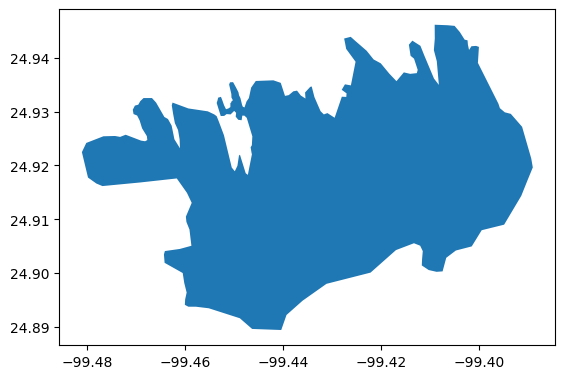

In [3]:
#Load data
presa_original = gpd.read_file("../../../data/external/temporal_todocker/{}.gpkg".format(city))
presa_original.plot()

Area of interest treatment

In [4]:
#Filter for relevant data
columns_tokeep = ['Name','geometry']
presa = presa_original[columns_tokeep]

#Create buffer for dam geometry
polygon = presa.to_crs("EPSG:6372").buffer(500)
polygon = polygon.to_crs("EPSG:4326")
polygon = gpd.GeoDataFrame(geometry=polygon).dissolve().geometry

#Review result
print(polygon.shape)
polygon.head(2)

(1,)


0    POLYGON ((-99.47569 24.92998, -99.47571 24.930...
Name: geometry, dtype: geometry

### Data download - Download and proccess rasters

In [5]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
df_len = aup.download_raster_from_pc(polygon, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query = query, satellite = satellite)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 236.80it/s]


### Data download - Create hexgrid from area of interest

In [6]:
hex_gdf = gpd.GeoDataFrame(polygon)
hex_gdf['res'] = res[0]

if len(res)>1:
#If there is more than one resolution
    for r in range(res[0]+1,res[-1]+1): #Skips res 8 because, originally, res 8 is already in original hex_gdf
        hex_tmp = aup.create_hexgrid(polygon, r)
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        hex_gdf = pd.concat([hex_gdf, hex_tmp],ignore_index = True, axis = 0)
        del hex_tmp

#If there is only one resolution
else:
    hex_gdf = aup.create_hexgrid(hex_gdf, res[0])
    hex_gdf.rename(columns={f'hex_id_{res[0]}':'hex_id'}, inplace=True)
    hex_gdf['res'] = res[0]
    
#Show
print(hex_gdf.shape)
hex_gdf.head(2)

(132098, 3)


,hex_id,geometry,res
0,8c48b5149d749ff,"POLYGON ((-99.41748 24.90971, -99.41738 24.909...",12
1,8c48b5a9648c3ff,"POLYGON ((-99.40471 24.94664, -99.40461 24.946...",12


## Data processing to hex and saving

### Data processing - Raster to hex

In [7]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)

    if save:
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

In [35]:
for r in list(hex_gdf.res.unique()):

    processing_chunk = 150000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)
    
    if len(hex_gdf_res)>processing_chunk:
        c_processing = len(hex_gdf_res)/processing_chunk
        
        for i in range(int(c_processing)):
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)
    else:
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

 12%|███████████████████▏                                                                                                                                     | 1/8 [11:31<1:20:38, 691.24s/it]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 3/8 [35:29<59:37, 715.50s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 5/8 [1:10:54<48:31, 970.41s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 7/8 [1:39:03<14:43, 883.76s/it]

  0%|                                                                                                                                                                                        | 0/8 [06:36<?, ?it/s]
